### Libraries and modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import czifile
import os
from tifffile import imsave
from skimage import filters


def czi_album(directory='', channel=0):
    """
    Read certain channel of each image inside a directory
    Input : directory (string), channel (integer)
    Output: image stack (numpy array)
    """
    stack = []
    for image in os.listdir(directory):
        image_path = os.path.join(directory, image)
        # checking if it is a file
        if os.path.isfile(image_path):
            try:
                # Read the image
                img = czifile.imread(image_path)
                # Append the Epifluorescent image and reshape it
                stack.append(img[0][channel].reshape(img.shape[2:4]))
            except:
                print(f'{image_path} is not a czi hyperstack')
    return np.array(stack)

### Read the images

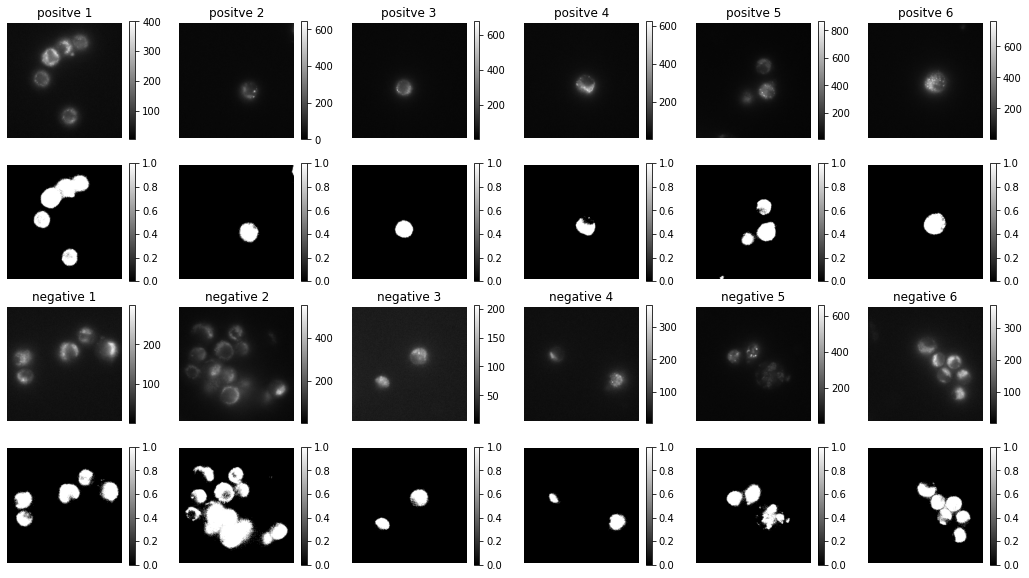

In [2]:
# Read all the images in each directory
epi_positive = czi_album(directory='Data/20220421_SHC_on_glass_Epi488/positive/', channel=2)
epi_negative = czi_album(directory='Data/20220421_SHC_on_glass_Epi488/negative/', channel=2)

# Subtract the base line
base_line = np.min([epi_positive.min(), epi_negative.min()])
epi_positive -= base_line
epi_negative -= base_line

# Save the stackes in tiff format
imsave('Data/20220421_SHC_on_glass_Epi488/positve.tif', epi_positive)
imsave('Data/20220421_SHC_on_glass_Epi488/negative.tif', epi_negative)

# Extract the segmented signals
signal_positive = np.array([img * (img > filters.threshold_otsu(img)) for img in epi_positive])
signal_negative = np.array([img * (img > filters.threshold_otsu(img)) for img in epi_negative])

# Plot all the images
plt.figure(figsize=(3*epi_positive.shape[0], 10))

for i, img in enumerate(epi_positive):
    plt.subplot(4, epi_positive.shape[0], i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f'positve {i+1}')
    plt.colorbar()
    
for i, img in enumerate(epi_positive):
    plt.subplot(4, epi_positive.shape[0], i+1+epi_positive.shape[0])
    plt.imshow(img > filters.threshold_otsu(img), cmap='gray')
    plt.axis('off')
    plt.colorbar()
    
for i, img in enumerate(epi_negative):
    plt.subplot(4, epi_positive.shape[0], i+1+2*epi_positive.shape[0])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f'negative {i+1}')
    plt.colorbar()
    
for i, img in enumerate(epi_negative):
    plt.subplot(4, epi_positive.shape[0], i+1+3*epi_positive.shape[0])
    plt.imshow(img > filters.threshold_otsu(img), cmap='gray')
    plt.axis('off')
    plt.colorbar()

plt.savefig('Data/20220421_SHC_on_glass_Epi488/summary')
plt.show()

### Comparison

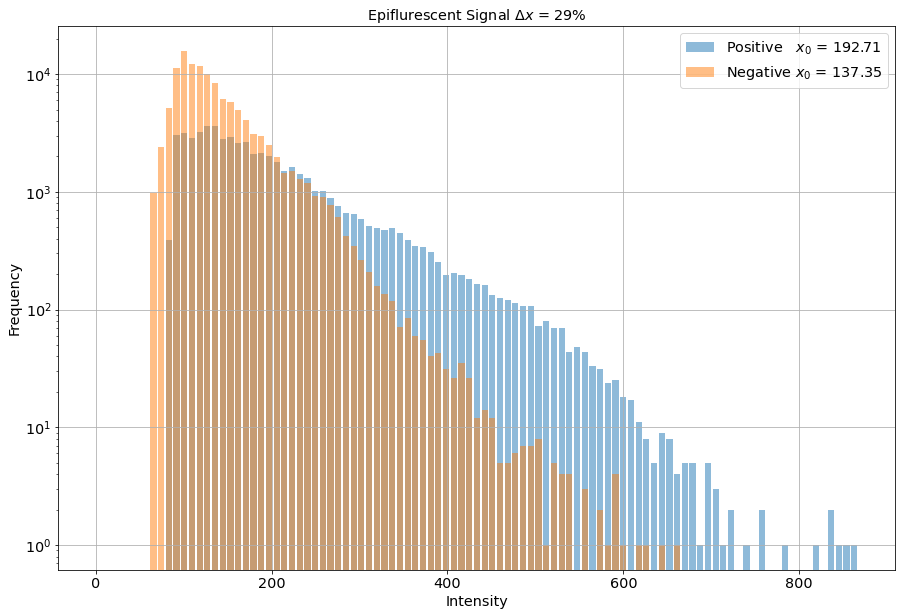

In [3]:
# Flat the array and exclud the zero
signal_positive = signal_positive[signal_positive != 0].ravel()
signal_negative = signal_negative[signal_negative != 0].ravel()

# plot a comparison of the two histogram
plt.figure(figsize=(15,10))
plt.hist(signal_positive, bins=np.linspace(0, signal_positive.max(), 100), rwidth=0.8, label=f'Positive   $x_0$ = {signal_positive.mean():.2f}', alpha=0.5)
plt.hist(signal_negative, bins=np.linspace(0, signal_positive.max(), 100), rwidth=0.8, label=f'Negative $x_0$ = {signal_negative.mean():.2f}', alpha=0.5)
plt.title(f'Epiflurescent Signal $\Delta x$ = {((signal_positive.mean() - signal_negative.mean())/ signal_positive.mean())*100:.0f}%', fontsize='x-large')
plt.xlabel('Intensity', fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.ylabel('Frequency', fontsize='x-large')
plt.yscale('log')
plt.legend(fontsize='x-large')
plt.grid()

plt.savefig('Data/20220421_SHC_on_glass_Epi488/comparison')
plt.show()